In [44]:
import sys 
sys.path.append('./../../src')

# others shit
from matplotlib import pyplot
from pandas import DataFrame
import numpy as np

from lib.stonk_jar import StonkJar
from lib.oscillators import stochastic

In [39]:
ticker = 'GME'
jar = StonkJar(ticker)
historical_pickle_name = "{0}.technical.D.historical.df.pkl".format(ticker)
data = jar.read_pickle_dataframe(historical_pickle_name)

In [40]:
data.describe()

,o,l,h,c,v,e_a,e_e,r_ss,r_s,r_h,r_b,r_sb
count,1794.000000,1794.000000,1794.000000,1794.000000,1.794000e+03,1.794000e+03,1794.000000,1794.0,1794.0,1794.0,1794.0,1794.0
mean,128.691088,130.574125,130.510833,132.123825,1.072568e+08,-5.300000e-01,-0.857116,0.0,0.0,0.0,0.0,0.0
std,5.532129,5.827971,5.596367,5.705862,3.031395e+07,2.221065e-16,0.000000,0.0,0.0,0.0,0.0,0.0
min,117.570000,120.500000,118.899000,121.670000,5.493006e+07,-5.300000e-01,-0.857116,0.0,0.0,0.0,0.0,0.0
25%,123.449000,124.940000,126.600000,127.930000,8.693979e+07,-5.300000e-01,-0.857116,0.0,0.0,0.0,0.0,0.0
50%,128.500000,129.200000,130.890000,131.685000,9.839056e+07,-5.300000e-01,-0.857116,0.0,0.0,0.0,0.0,0.0
75%,133.590000,135.580000,134.870000,136.310000,1.210473e+08,-5.300000e-01,-0.857116,0.0,0.0,0.0,0.0,0.0
max,141.370000,143.600000,143.160000,145.090000,1.925415e+08,-5.300000e-01,-0.857116,0.0,0.0,0.0,0.0,0.0


Set `vals` to be the last 90 days of candle information, from t - 90 to t

In [41]:
fastk_days = 7
slowk_days = 3
slowd_days = 3

data.index = data['ts']
data.sort_index()
data.drop_duplicates()

,ts,o,l,h,c,v,e_a,e_e,r_ss,r_s,r_h,r_b,r_sb
ts,,,,,,,,,,,,,
2020-12-01 00:00:00,2020-12-01 00:00:00,120.01,121.01,122.720,123.4693,128166803,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0
2020-12-02 00:00:00,2020-12-02 00:00:00,120.89,122.02,123.080,123.3700,89004195,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0
2020-12-03 00:00:00,2020-12-03 00:00:00,122.21,123.52,122.940,123.7800,78967630,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0
2020-12-04 00:00:00,2020-12-04 00:00:00,121.52,122.60,122.250,122.8608,78260421,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0
2020-12-07 00:00:00,2020-12-07 00:00:00,122.25,122.31,123.750,124.5700,86711990,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-04 00:00:00,2021-03-04 00:00:00,118.62,121.75,120.130,123.6000,177275300,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0
2021-03-05 14:30:00,2021-03-05 14:30:00,117.57,120.98,118.900,121.6700,71986254,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0
2021-03-05 14:30:00,2021-03-05 14:30:00,117.57,120.98,118.899,121.6700,71996083,-0.53,-0.857116,0.0,0.0,0.0,0.0,0.0


Create oscillators from the day config.

Start from the end, and generate oscillator values in day config chunks going to the start of the dataset. This will result in a reversed array of oscillator values that will need to be re-reversed.

In [73]:
days = 90

oscillators = [[0, 0, 0]] * days
in_range = list(data['c'].tail(days))

for i in range(days, 0, -1):
    num = max(fastk_days, max(slowk_days, slowd_days))
    vals = in_range[i-num:i]
    if len(vals) >= num:
        fastk, slowk, slowd = stochastic(vals, fastk_days = fastk_days,
                                         slowk_days = slowk_days,
                                         slowd_days = slowd_days)
        oscillators[i-1] = [fastk, slowk, slowd]

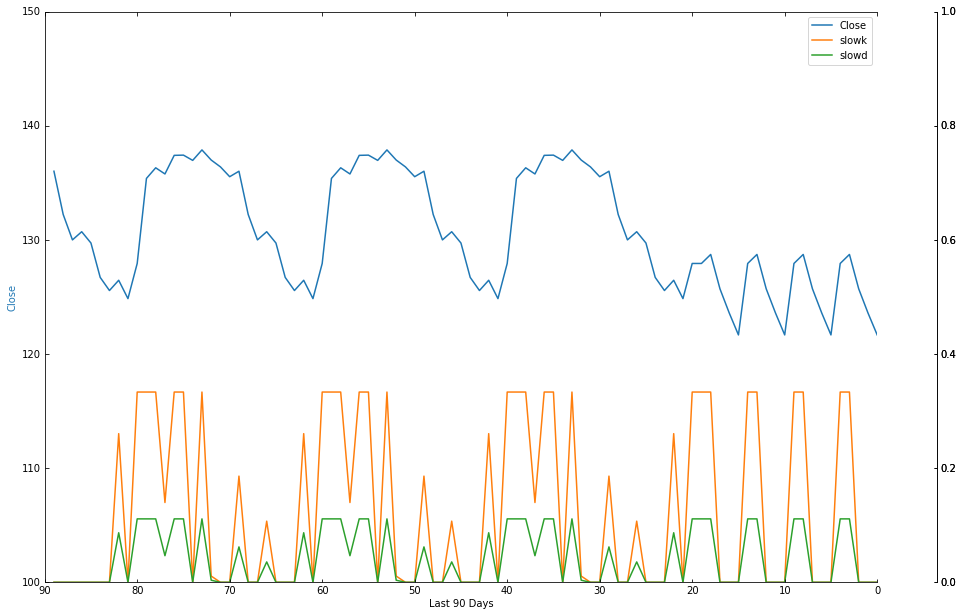

In [81]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig = figure(num=None, figsize=(8, 6), dpi=72, facecolor='w', edgecolor='k')
fig.set_size_inches(18.5, 10.5, forward=True)

host = host_subplot(111, axes_class=AA.Axes)

plt.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

offset = 60
new_fixed_axis = par1.get_grid_helper().new_fixed_axis
par1.axis["right"] = new_fixed_axis(loc="right", axes=par1,
                                        offset=(offset, 0))

par1.axis["right"].toggle(all=True)
par2.axis["right"] = par1.axis["right"]

host.set_xlim(0, 90)
host.set_ylim(100, 150)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)

host.set_xlabel("Last 90 Days")
host.set_ylabel("Close")

host.invert_xaxis()

chart_data = list(data['c'].tail(90))
chart_data.reverse()

slowk_data = list([i[1] for i in oscillators])
slowk_data.reverse()

slowd_data = list([i[2] for i in oscillators])
slowd_data.reverse()

p1, = host.plot(chart_data, label="Close")
p2, = par1.plot(slowk_data, label="slowk")
p3, = par2.plot(slowd_data, label="slowd")

host.legend()

host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())